## Data

In [1]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

In [2]:
#First look
head(train.data)
#Maximum and Minimum value of output variable
max <- which.max(train.data$VALENCE.PLEASANTNESS)
min <- which.min(train.data$VALENCE.PLEASANTNESS)
train.data$VALENCE.PLEASANTNESS[min]
train.data$VALENCE.PLEASANTNESS[max]
#Dimension of data
dim(train.data)

,Intensity,VALENCE.PLEASANTNESS,SWEETORSOUR,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
,<fct>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,low,45,FALSE,302.0,208.33,5.952,19.698,34.491,21.523,39.571,...,0,0,1,0,1,0,1,0,1,0
2,high,49,TRUE,72.6,122.18,6.431,11.349,18.745,12.261,21.285,...,0,0,0,0,0,0,0,0,0,0
3,high,56,TRUE,259.0,242.29,7.572,20.832,32.167,21.693,35.535,...,0,0,1,0,1,1,1,0,1,1
4,high,7,FALSE,56.6,88.12,6.294,7.537,14.189,7.955,16.080,...,0,0,0,0,0,0,0,0,0,0
5,low,51,FALSE,84.7,136.21,6.191,12.876,21.629,14.023,24.701,...,0,0,0,0,0,0,0,0,0,0
6,high,21,FALSE,160.0,192.28,6.409,17.644,29.723,19.000,33.740,...,0,0,0,0,1,0,1,0,1,0


[1] 0

[1] 98

[1]  708 4872

**Output variable (dependent variable): VALENCE.PLEASANTNESS**
- min. value (in the training set) = 0
- max. value (in the training set) = 98

**Input variables (predictors):**
- 4870 different predictors
- Intensity is a categorical variable with the levels low and high

**SWEETORSOUR:**
- output variable for the second task
- not included in the test set
- not usable for the regression task

## Variance

In [12]:
#convert the variable intensity into 2=low and 1=high (so that we can apply variance and correlation)
numeric.intensity <- as.numeric(train.data$Intensity)


In [13]:
#searching for input variables with zero variance (without the varible Intensity)
y <- train.data$VALENCE.PLEASANTNESS
x <- train.data[, -c(2,3)]
x$Intensity <- numeric.intensity
n.before <- dim(x)[2] #numbers of predictors before the reduction
idx.zero.var <- apply(x, 2, var) == 0 
x <- x[,!idx.zero.var]
n.after <- dim(x)[2] #numbers of predictors after the reduction

cat("Thereby we could reduce the number of predictors from" , n.before , " to " , n.after)

Thereby we could reduce the number of predictors from 4870  to  3028

## Full linear Regression

In [46]:
#split the training data in a training set and a validation set
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)
train.x <- as.matrix(x[idx.train,])
train.y <- as.matrix(y[idx.train])
val.x <- as.matrix(x[-idx.train,])
val.y <- as.matrix(y[-idx.train])

train <- x[idx.train,]
train$VALENCE.PLEASANTNESS <- y[idx.train]
validation <- x[-idx.train,]
validation$VALENCE.PLEASANTNESS <- y[-idx.train]

#full linear regression
full.linear.fit <- lm(VALENCE.PLEASANTNESS ~ ., train)

In [47]:
full.prediction.validation <- predict(full.linear.fit, validation)
MSE.validation <- mean((full.prediction - validation$VALENCE.PLEASANTNESS)^2)

full.prediction.train <- predict(full.linear.fit, train)
MSE.train <- mean((full.prediction.train - train$VALENCE.PLEASANTNESS)^2)

cat("We obtained a validation MSE = ", MSE.validation, " and a training MSE = ", MSE.train)

Warning message in predict.lm(full.linear.fit, validation):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(full.linear.fit, train):
"prediction from a rank-deficient fit may be misleading"


We obtained a validation MSE =  226371353051  and a training MSE =  137.9714

We can see that the full linear model overfits the data highly. Therefore we have a much more higher validation MSE than training MSE.

## Linear Regression with Lasso Regularization and K-Fold Cross Validation

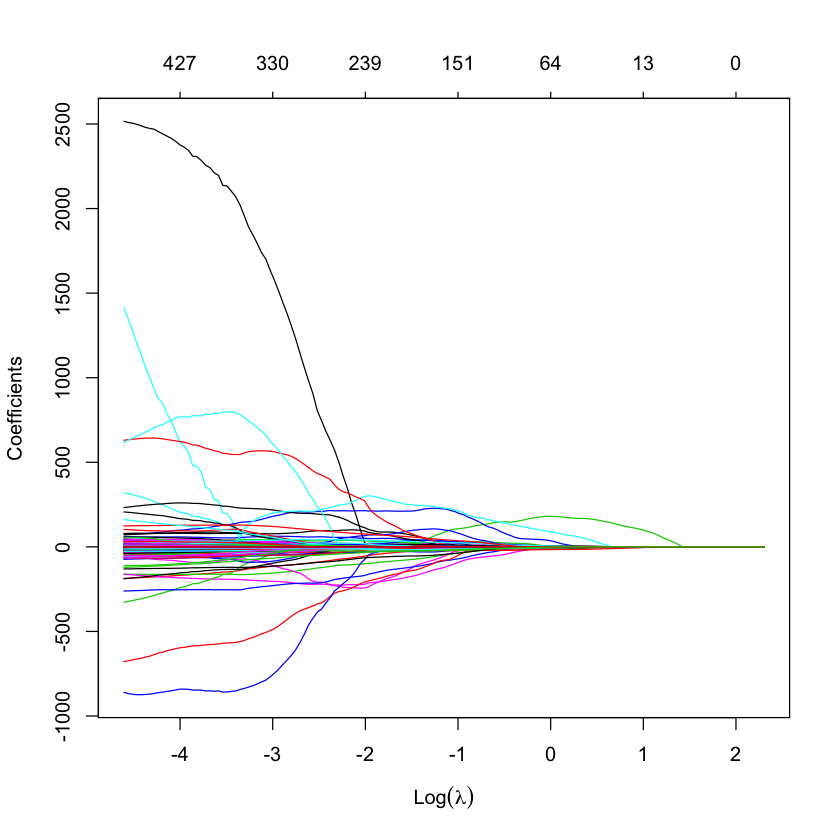

In [61]:
library(glmnet)


#split the training data in a training set and a validation set
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)
train.x <- as.matrix(x[idx.train,])
train.y <- as.matrix(y[idx.train])
val.x <- as.matrix(x[-idx.train,])
val.y <- as.matrix(y[-idx.train])

#Lasso model
lasso.mod <- glmnet(train.x,train.y, alpha = 1, lambda = 10^seq(1, -2, length = 150))
plot(lasso.mod, "lambda", xlab = parse(text = "Log(lambda)"))

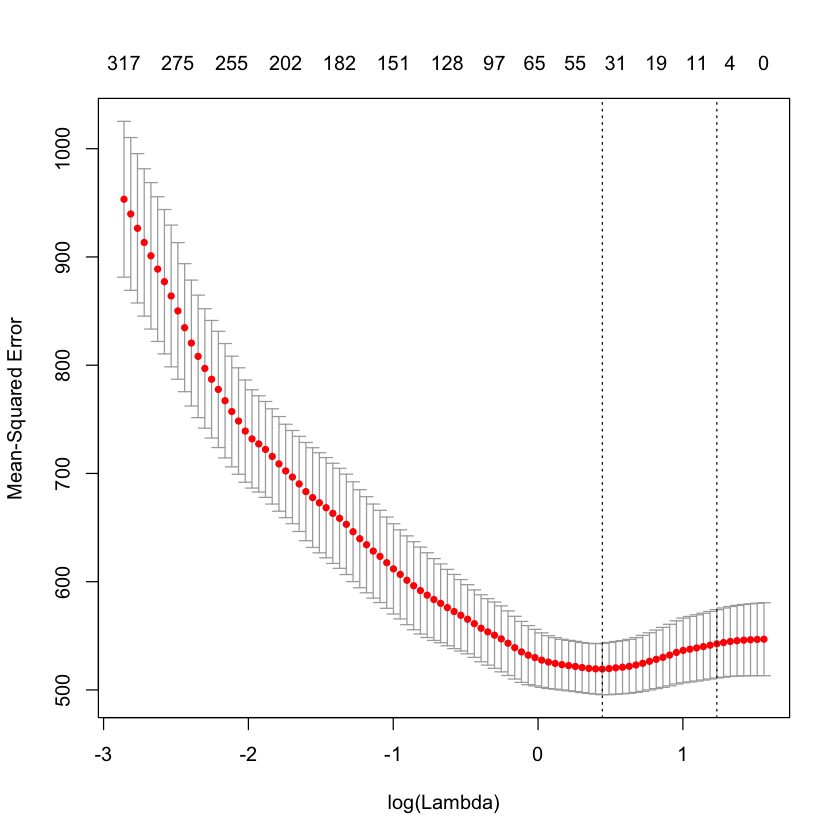

In [62]:
#5-fold cross-validation to find the optimal value for the parameter lambda
cv.lasso <- cv.glmnet(train.x, train.y, alpha = 1, nfold = 5)
plot(cv.lasso)

One can see that it is clearly better to not include all variables for a linear regression (as expected).  

In [63]:
#best prediction 
best.lasso <- glmnet(train.x, train.y, alpha = 1, lambda = cv.lasso$lambda.min)
pred <- predict(best.lasso, s = cv.lasso$lambda.min, newx = as.matrix(val.x))

#MSE with best lasso prediction 
mean((pred - val.y)^2)

[1] 452.1432

## Correlation

In [64]:
library(corrplot)
library(caret)
library(corrplot)
library(plyr)

#searching for variables with correlation = 1
corrData = scale(x, center=TRUE, scale = TRUE)  # normalize the data frame. This will also convert to a matrix. 
corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)

highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 1)  # removes all indices of features which have a correltion of 0.99 or above
length(highlyCorrelated)

[1] 0

There are zero variables which have a correlation index of 1. Hence no variables are completly correlated to each other. We can try to reduce the predictors with 0.95 correlation (or higher) and see if the linear Regression with Lasso Regularization and K-Fold Cross Validation gives us a smaller validation MSE.

In [65]:
#searching for variables with correlation = 0.95
corrData = scale(x, center=TRUE, scale = TRUE)  # normalize the data frame. This will also convert to a matrix. 
corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)
highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 0.95)  # removes all indices of features which have a correlation of 0.95 or above
highlyCorrCol <- colnames(x)[highlyCorrelated]
corr.x <- x[, -which(colnames(x) %in% highlyCorrCol)]  #Data frame with only uncorrelated data


It leads to a reduction of dimension from 3026 to 1194 predictors.
Now, let's split the training data into a training and a validation set. We will then test if the prediction on the validation set are better with uncorrelated data than correlated data with Lasso regularization on both models. 

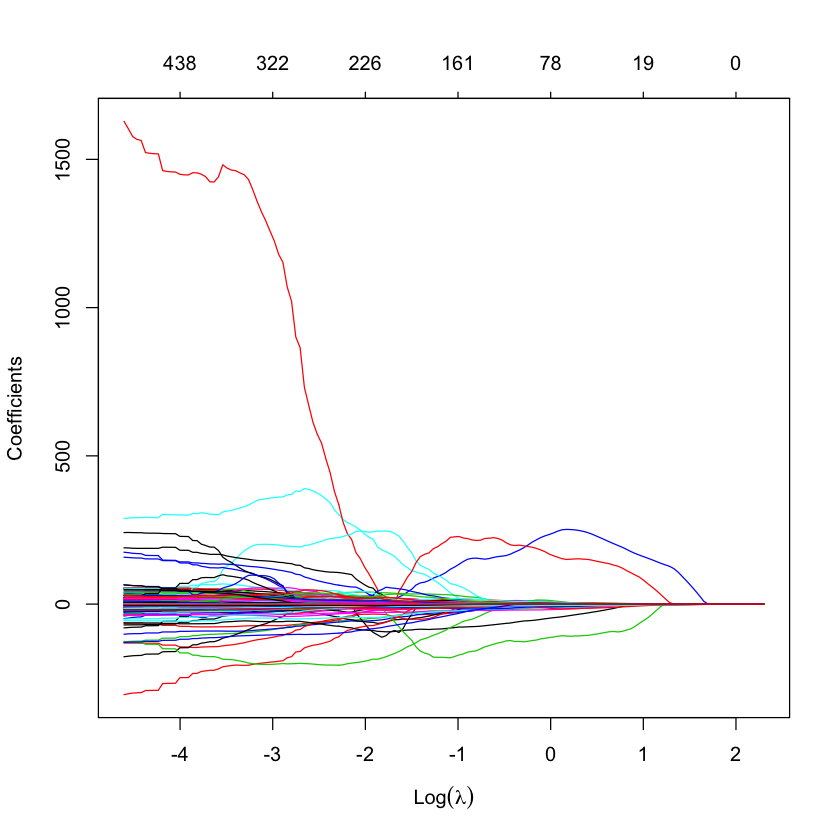

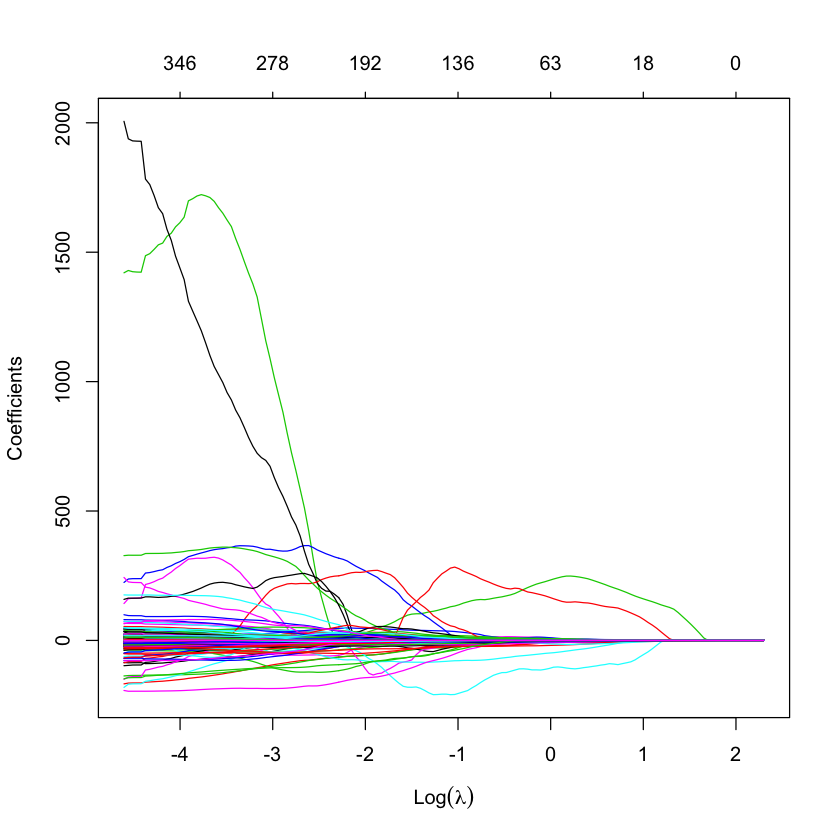

In [66]:
#split the training data in a training set and a validation set (one time with all predictors (var != 0), one time without to high correlated predictors

len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

train.x <- as.matrix(x[idx.train,])
train.y <- as.matrix(y[idx.train])
val.x <- as.matrix(x[-idx.train,])
val.y <- as.matrix(y[-idx.train])

corr.train.x <- as.matrix(corr.x[idx.train,])
corr.train.y <- as.matrix(y[idx.train])
corr.val.x <- as.matrix(corr.x[-idx.train,])
corr.val.y <- as.matrix(y[-idx.train])

#Lasso model
lasso.mod <- glmnet(train.x,train.y, alpha = 1, lambda = 10^seq(1, -2, length = 150))
plot(lasso.mod, "lambda", xlab = parse(text = "Log(lambda)"))

corr.lasso.mod <- glmnet(corr.train.x,corr.train.y, alpha = 1, lambda = 10^seq(1, -2, length = 150))
plot(corr.lasso.mod, "lambda", xlab = parse(text = "Log(lambda)"))

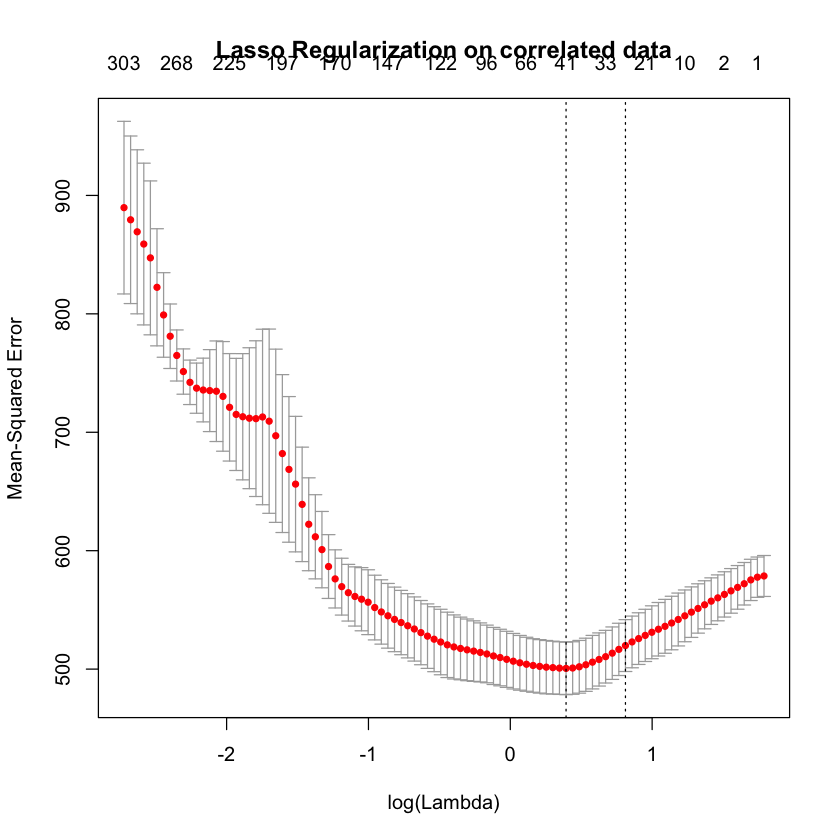

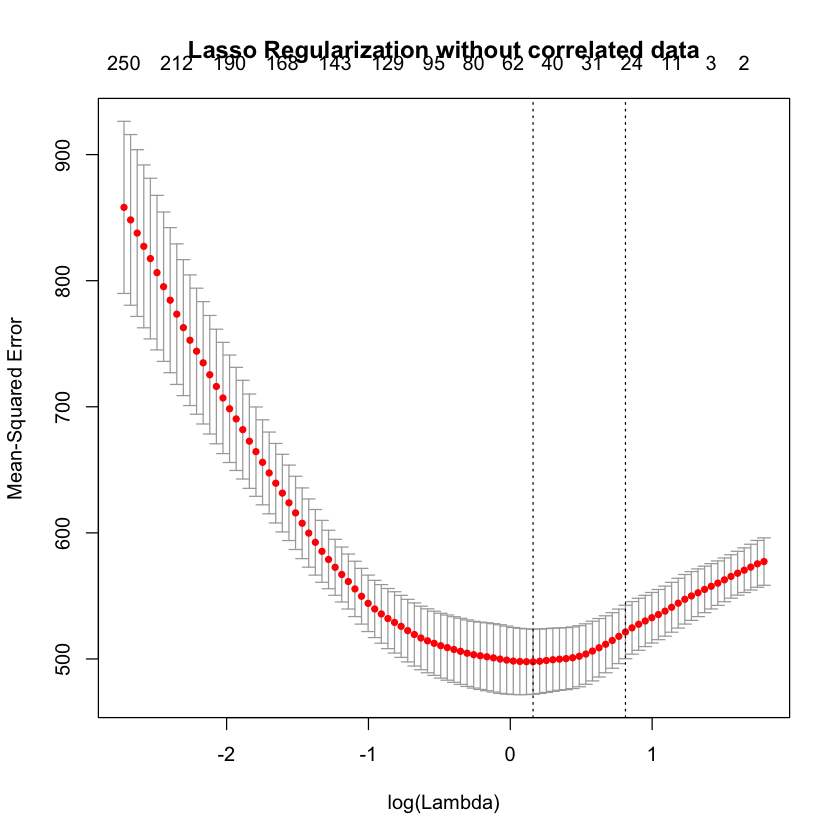

In [67]:
#5-fold cross-validation to find the optimal value for the parameter lambda
cv.lasso <- cv.glmnet(train.x, train.y, alpha = 1, nfold = 5)
plot(cv.lasso, main = "Lasso Regularization on correlated data")

corr.cv.lasso <- cv.glmnet(corr.train.x, corr.train.y, alpha = 1, nfold = 5)
plot(corr.cv.lasso, main = "Lasso Regularization without correlated data")

In [240]:
#best prediction 
best.lasso <- glmnet(train.x, train.y, alpha = 1, lambda = cv.lasso$lambda.min)
pred <- predict(best.lasso, s = cv.lasso$lambda.min, newx = as.matrix(val.x))

corr.best.lasso <- glmnet(corr.train.x, corr.train.y, alpha = 1, lambda = corr.cv.lasso$lambda.min)
corr.pred <- predict(corr.best.lasso, s = corr.cv.lasso$lambda.min, newx = as.matrix(corr.val.x))

#MSE with best lasso prediction 
mean((pred - val.y)^2)
mean((corr.pred - corr.val.y)^2)

[1] 485.1952

[1] 479.8681

Since the MSE does not diminish significantly when we remove correlated variables, we conserve all 3028 predictors for the further analyse.

Additionally, we can see that the MSE is around 450-520. 

In the same way, let's perform Ridge Regularization to see if it improves our model.

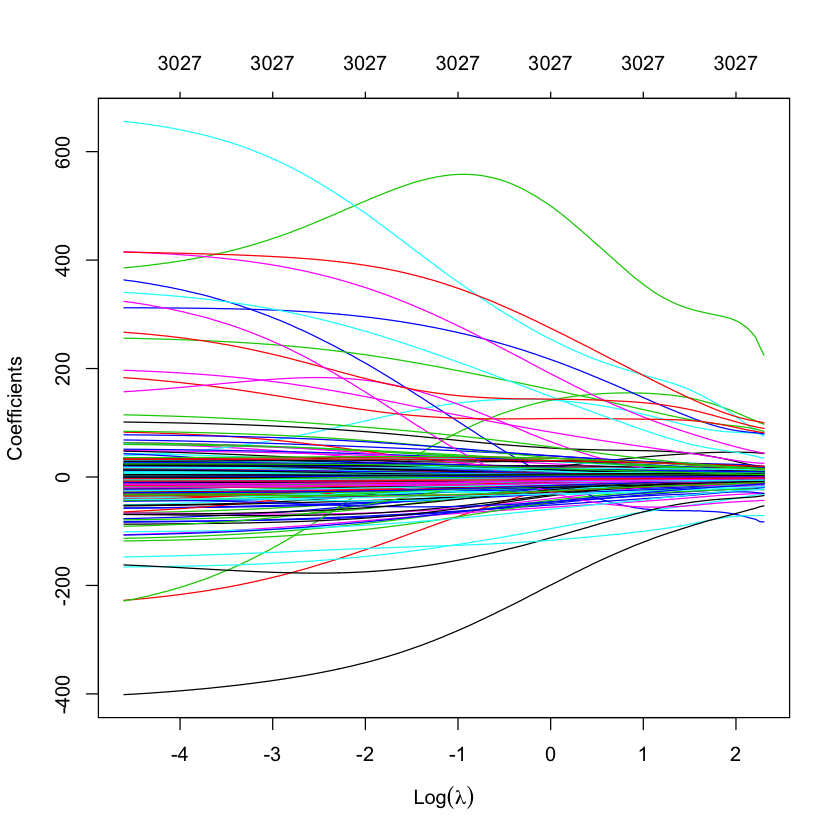

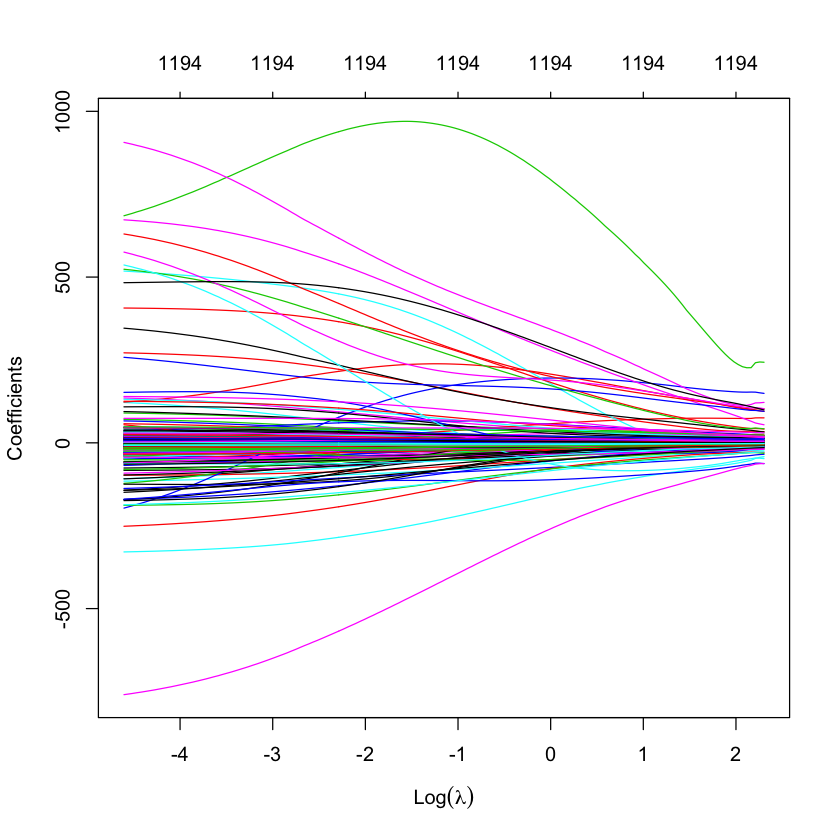

In [74]:
#RIDGE REGRESSION : Alpha = 0
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

train.x <- as.matrix(x[idx.train,])
train.y <- as.matrix(y[idx.train])
val.x <- as.matrix(x[-idx.train,])
val.y <- as.matrix(y[-idx.train])

corr.train.x <- as.matrix(corr.x[idx.train,])
corr.train.y <- as.matrix(y[idx.train])
corr.val.x <- as.matrix(corr.x[-idx.train,])
corr.val.y <- as.matrix(y[-idx.train])

#Lasso model
lasso.mod <- glmnet(train.x,train.y, alpha = 0, lambda = 10^seq(1, -2, length = 150))
plot(lasso.mod, "lambda", xlab = parse(text = "Log(lambda)"))

corr.lasso.mod <- glmnet(corr.train.x,corr.train.y, alpha = 0, lambda = 10^seq(1, -2, length = 150))
plot(corr.lasso.mod, "lambda", xlab = parse(text = "Log(lambda)"))

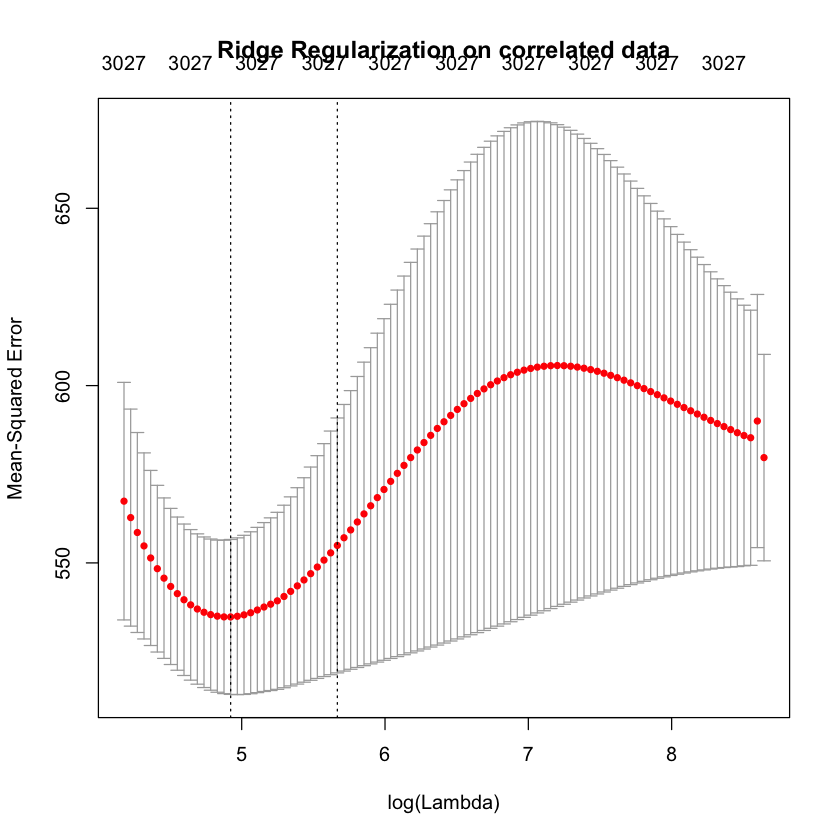

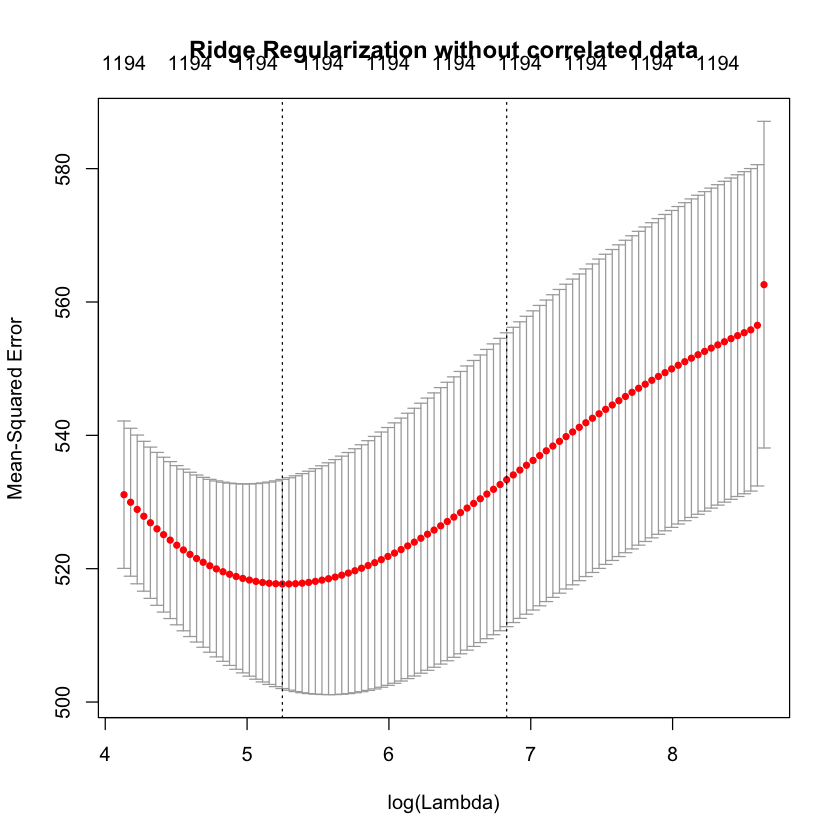

In [75]:
#5-fold cross-validation to find the optimal value for the parameter lambda
cv.lasso <- cv.glmnet(train.x, train.y, alpha = 0, nfold = 5)
plot(cv.lasso, main = "Ridge Regularization on correlated data")

corr.cv.lasso <- cv.glmnet(corr.train.x, corr.train.y, alpha = 0, nfold = 5)
plot(corr.cv.lasso, main = "Ridge Regularization without correlated data")

In [76]:
#best prediction 
best.lasso <- glmnet(train.x, train.y, alpha = 1, lambda = cv.lasso$lambda.min)
pred <- predict(best.lasso, s = cv.lasso$lambda.min, newx = as.matrix(val.x))

corr.best.lasso <- glmnet(corr.train.x, corr.train.y, alpha = 1, lambda = corr.cv.lasso$lambda.min)
corr.pred <- predict(corr.best.lasso, s = corr.cv.lasso$lambda.min, newx = as.matrix(corr.val.x))

#MSE with best lasso prediction 
mean((pred - val.y)^2)
mean((corr.pred - corr.val.y)^2)

[1] 479.9474

[1] 479.9474

Ridge Regression does not result in a significant reduction in the MSE and does not change with correlated or uncorrelated variables. 

## Forward Selection with Cross-Validation

In [68]:
library(tidymodels)
library(leaps)

#functions 
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}


evaluate <- function(fold, fit, formula = VALENCE.PLEASANTNESS ~ .) {
    valid.set <- assessment(fold)
    sapply(seq(1, fit$nvmax - 1),
           function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict(fit, valid.set, id, formula))^2))
}

fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ .) {
    fit <- regsubsets(formula, analysis(fold), method = "forward", nvmax = 60)
    evaluate(fold, fit)
}

#data
full.data <- x
full.data$VALENCE.PLEASANTNESS <- y
validation.data <- vfold_cv(full.data, v = 5)           
           
cv.errors <- sapply(validation.data$splits, fit_and_evaluate)
mean.cv.errors <- rowMeans(cv.errors)

── Attaching packages ────────────────────────────────────── tidymodels 0.1.2 ──
✔ broom     0.7.2      ✔ recipes   0.1.15
✔ dials     0.0.9      ✔ rsample   0.0.8 
✔ dplyr     1.0.2      ✔ tibble    3.0.4 
✔ infer     0.5.3      ✔ tidyr     1.1.2 
✔ modeldata 0.1.0      ✔ tune      0.1.2 
✔ parsnip   0.1.4      ✔ workflows 0.2.1 
✔ purrr     0.3.4      ✔ yardstick 0.0.7 
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::accumulate()      masks foreach::accumulate()
✖ dplyr::arrange()         masks plyr::arrange()
✖ purrr::compact()         masks plyr::compact()
✖ dplyr::count()           masks plyr::count()
✖ purrr::discard()         masks scales::discard()
✖ tidyr::expand()          masks Matrix::expand()
✖ dplyr::failwith()        masks plyr::failwith()
✖ dplyr::filter()          masks stats::filter()
✖ dplyr::id()              masks plyr::id()
✖ dplyr::lag()             masks stats::lag()
✖ purrr::lift()            masks caret::lift()
✖ dplyr

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“2710  linear dependencies found”

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“2710  linear dependencies found”

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“2704  linear dependencies found”

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“2703  linear dependencies found”

Reordering variables and trying again:


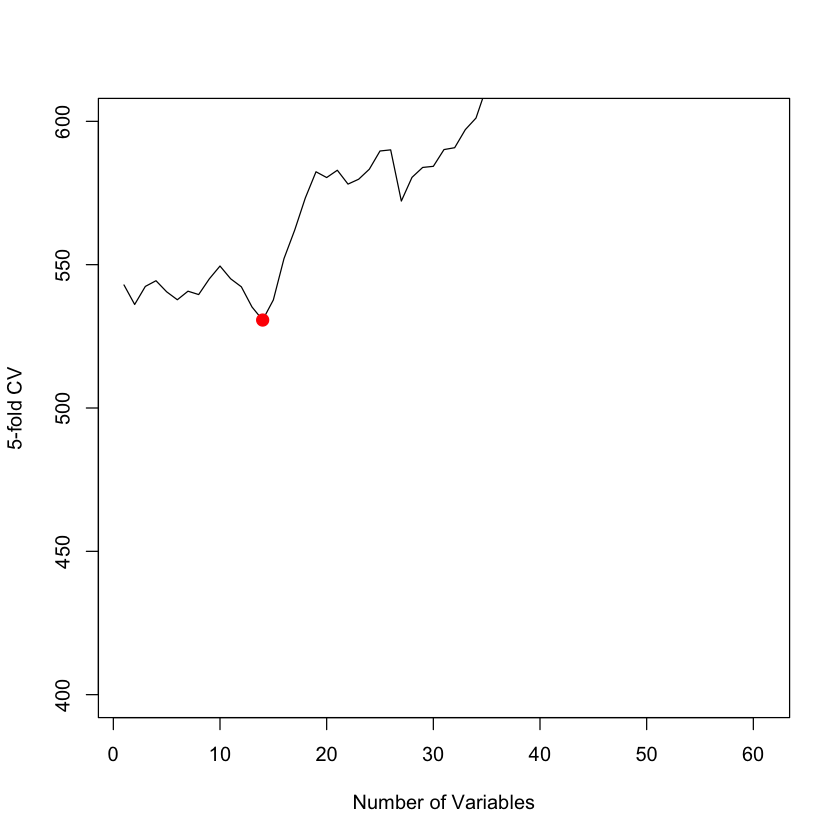

In [69]:
#plot the obtained data
plot(mean.cv.errors, type = "l", ylim = c(400, 600), xlab = "Number of Variables", ylab = "5-fold CV")
cv.min <- which.min(mean.cv.errors)
points(cv.min, mean.cv.errors[cv.min], col = "red", cex = 2, pch = 20)
abline(sd(full.data$VALENCE.PLEASANTNESS), 0, lty = "dashed")

We can see that the best predictions are obtained with a small number of variables (14 variables). 

In [82]:
poly.train <- train.data[, -c(3)]
poly.train.X  <- train.data[, -c(2,3)]

Warning message in mean.default(x):
“argument is not numeric or logical: returning NA”Warning message in Ops.factor(left, right):
“‘-’ not meaningful for factors”

ERROR: Error in FUN(X, Y, ...): argument non numérique pour un opérateur binaire


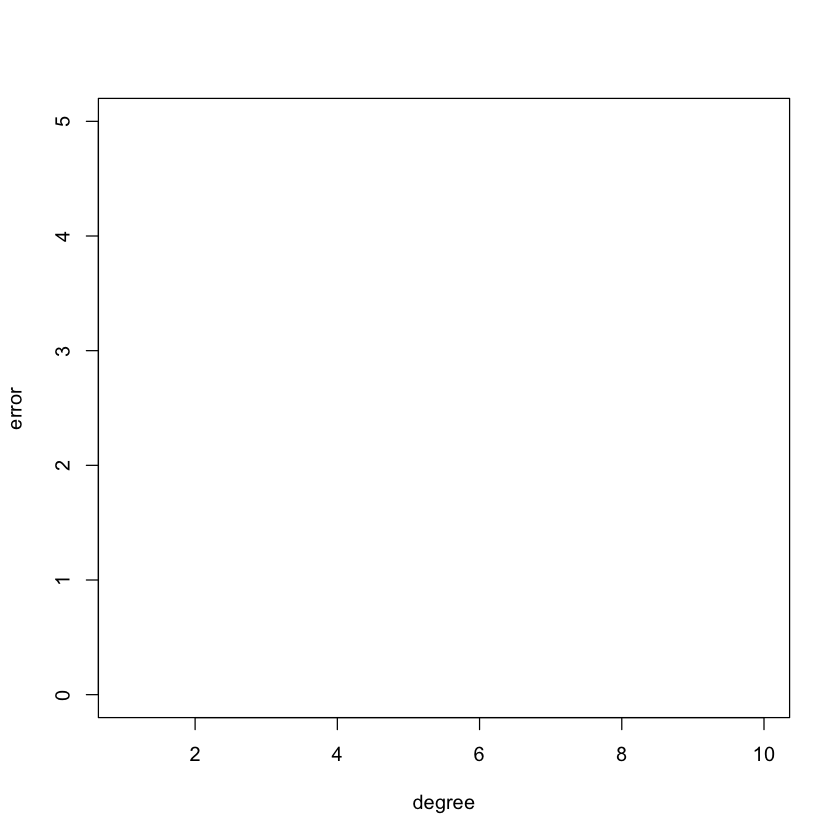

In [84]:

fit.and.evaluate <- function(d, train, validat) {
    fit <- lm(VALENCE.PLEASANTNESS~ poly(poly.train.X, d), train)
    c(mean((train$VALENCE.PLEASANTNESS - predict(fit, train))^2),
      mean((validat$VALENCE.PLEASANTNESS - predict(fit, validat))^2))
}
evaluate.split <- function(idx.train) {
    d <- seq(1:10)
    poly.train[idx.train,]
    sapply(d, fit.and.evaluate, poly.train[idx.train,], poly.train[-idx.train,])
}
set.seed(17)
plot(c(), ylab = "error", xlab = "degree", xlim = c(1, 10), ylim = c(0, 5)) # creates an empty plot
#plot(c(), ylab = "error", xlab = "degree") # creates an empty plot
for (i in 1:10) { # fit and evaluate for 20 different splits
    idx.train <- sample(nrow(poly.train), nrow(poly.train)*2/3)
    res <- evaluate.split(idx.train)
    optimal.d <- which.min(res[2,])  # the which.min function finds the argmin of the vector res[2,]
    lines(res[1,], type = 'l', lwd = .5, col = 'red')
    lines(res[2,], type = 'l', lwd = .5, col = 'blue')
    points(optimal.d, res[2,optimal.d], col = 'blue', pch = 19) # mark with a dot the optimal degree
}
legend("topright", legend = c("training", "validation"), col = c("red", "blue"), lty = 1)